In [1]:
#%pip install scikit-learn

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.preprocessing import MinMaxScaler

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [20]:
df = getTickerData('btc-usd', '729d', '1h')
df = df.drop(columns={'Volume', 'Adj Close', 'Open', 'High', 'Low'})
df = df.rename(columns={'Close': 'close', 'Datetime': 'date'})
#df['date'] = pd.to_datetime(df['date'])
df.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17241 entries, 0 to 17240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    17241 non-null  datetime64[ns, UTC]
 1   close   17241 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 269.5 KB


In [21]:
scaler = MinMaxScaler()
df3 = pd.DataFrame(scaler.fit_transform(df[df.drop(columns={'date'}).columns]), columns=[df[df.drop(columns={'date'}).columns]])
df3

,close
0,0.795869
1,0.806528
2,0.801112
3,0.802955
4,0.800689
...,...
17236,0.258602
17237,0.257517
17238,0.257674
17239,0.255419


In [22]:
rn = random.randint(0, df.value_counts().sum())
i=0
df.shape[0] - rn

11442

46551.76171875


,date,close
5799,2022-01-05 09:00:00+00:00,46792.843750
5800,2022-01-05 10:00:00+00:00,46786.222656
5801,2022-01-05 11:00:00+00:00,46266.492188
5802,2022-01-05 12:00:00+00:00,46242.824219
5803,2022-01-05 13:00:00+00:00,46400.050781


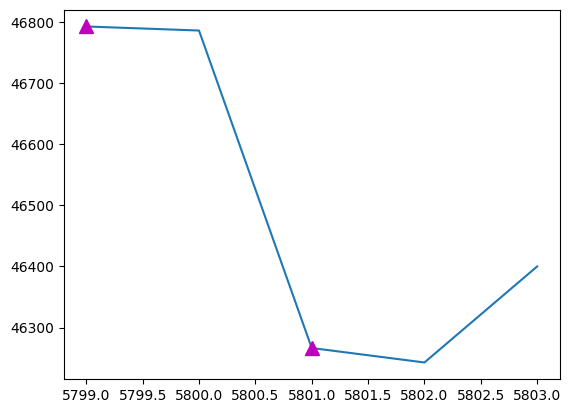

In [23]:
df2 = df.iloc[rn+i:rn+5+i,:]
final_value = df.loc[rn+5+i]['close']
close_value = df.loc[rn+4+i]['close']
plt.plot(df2['close'])
plt.plot(df2['close'], '^', markersize=10, color='m', label = 'buying signal', markevery = [True, False, True, False, False])
print(final_value)
i+=1
df2

In [24]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()
        scaler = MinMaxScaler()
        self.df = pd.DataFrame(scaler.fit_transform(df[df.drop(columns={'date'}).columns]), columns=[df[df.drop(columns={'date'}).columns]])
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(2) # 0-short pos || 1-long pos
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.random_index = random.randint(0, df.value_counts().sum())
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        
        self.long_pos = []
        self.short_pos = []
        
    def step(self, action):
        if action == 0:
            self.short_pos.append(True)
            self.long_pos.append(False)
        else:
            self.short_pos.append(False)
            self.long_pos.append(True)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        
        reward = self.calculate_reward(action)
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
        
        observation = self.get_observation()
        info = {}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_index = random.randint(0, df.value_counts().sum())
        self.done = False
        self.current_step = 0
        self.long_pos.clear()
        self.short_pos.clear()
        next_observation = self.get_observation(is_random=True)
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        return next_observation
    
    def get_observation(self, is_random=False):
        needed_space = self.window_size + self.n_steps
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum())
            if df.shape[0] - self.random_index < needed_space+1:
                self.random_index = df.shape[0] - needed_space
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def render_final(self):
        final_observation = self.df.iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+self.n_steps]
        win_rate = sum(n == 1 for n in self.long_pos) / self.n_steps
        loss_rate = 1 - win_rate
        
        self.short_pos.append(False)
        self.long_pos.append(False)
        plt.figure(figsize=(10,5))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'buying signal', markevery = self.long_pos)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'selling signal', markevery = self.short_pos)
        plt.title("Final result of the last trading session")
        plt.legend()
        plt.plot()
        
        return win_rate, loss_rate
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:
        if action == 0:
            if self.next_value < self.final_value:
                reward = 1
            else:
                reward = -1
        if action == 1:
            if self.next_value > self.final_value:
                reward = 1
            else:
                reward = -1
                
        return reward"""
        raise NotImplementedError    

In [25]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
    
    def calculate_reward(self, action):
        if action == 0:
            if self.next_value < self.final_value:
                reward = 1
            else:
                reward = -1
        if action == 1:
            if self.next_value > self.final_value:
                reward = 1
            else:
                reward = -1
                
        return reward

In [26]:
env = Trading(df, window_size=90, n_steps=20)

In [27]:
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


win rate - 0.55
loss rate - 0.44999999999999996
episode - 1 || score - 2


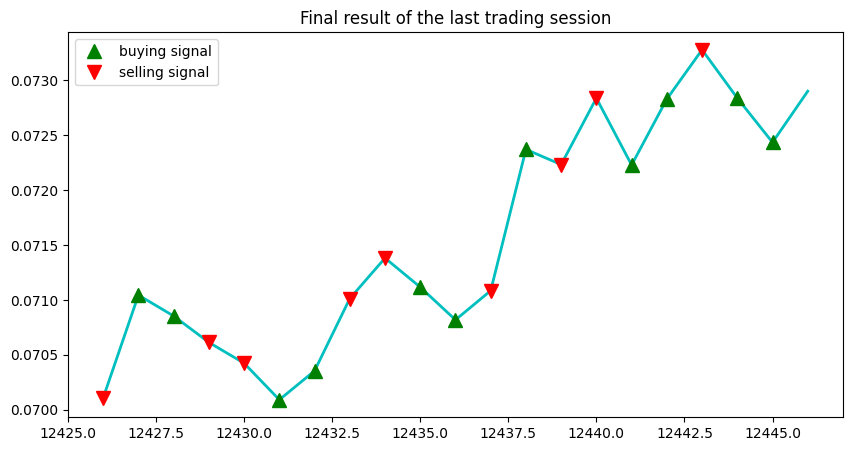

In [31]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
    win_rate, loss_rate = env.render_final()
    print(f'win rate - {win_rate}')
    print(f'loss rate - {loss_rate}')
    print(f'episode - {n} || score - {score}')

In [32]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [33]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [34]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [35]:
model.learn(total_timesteps=30000, callback=callback)

Logging to ./logs/RecurrentPPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 156      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.667        |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 6.618444e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance  

In [475]:
loaded_model = RecurrentPPO.load('./train/best_model_10000.zip')

In [537]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(1.2, 4.4)

episode - 1 || score - 2


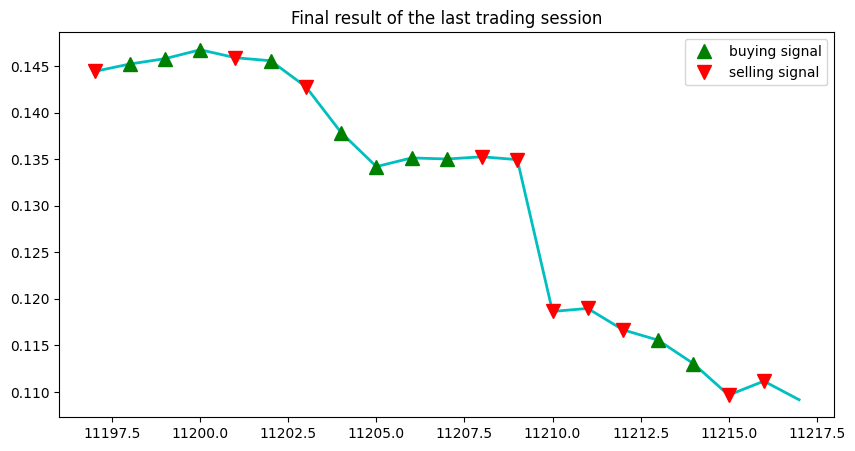

In [46]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action, lstm_cells = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
    env.render_final()
    print(f'episode - {n} || score - {score}')